# Ciclope voxel uFE pipeline @ JCW_2022
From a CT image of trabecular bone to voxel-uFE model solution in Calculix

Created on:  23.05.2021 <br />
Last update: 10.06.2022 <br />

- Data source: LHDL project (IOR Bologna, Italy)
- More info on the dataset source [here](http://projects.kmi.open.ac.uk/lhdl/)
- For info on the solver visit the [Calculix homepage](http://www.calculix.de/)

---
The pipeline can be executed from the command line using the **ciclope** command: <br />
```commandline
python ciclope.py test_data/LHDL/3155_D_4_bc/cropped/3155_D_4_bc_0000.tif test_data/LHDL/3155_D_4_bc/3155_D_4_bc.inp -vs 0.0195 0.0195 0.0195 --voxelfe --template input_templates/tmp_example01_comp_static_bone.inp
```

Type `python ciclope.py -h` to display the ciclope help with detailed information on command line arguments.


![](./../test_data/steel_foam/IMG_20201121_225702.jpg)

## Configuration

In [ ]:
import sys
sys.path.append('./../../')

In [ ]:
import numpy as np
import dxchange
import matplotlib
import matplotlib.pyplot as plt

import mcubes
from scipy import ndimage, misc
from skimage.filters import threshold_otsu, gaussian
from skimage import measure, morphology

from recon_utils import read_tiff_stack, plot_midplanes
import ciclope

In [ ]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

#### Load input data

In [ ]:
input_file = './../../test_data/LHDL/3155_D_4_bc/cropped/3155_D_4_bc_0000.tif'

Input data description

|Scan parameters|   |
|:-|:-|
|Lab|LTM@IOR Bologna|
|Sample|Human trabecular bone|
|Energy| |
|Voxel size|19.5 micron|
|Preliminary operations|cropped to 200x200x200 (4mm side)|

Read the input data and define an array of the voxelsize

In [ ]:
data_3D = read_tiff_stack(input_file)
vs = np.ones(3)*19.5e-3*4 # [mm]

Inspect the dataset

In [ ]:
plot_midplanes(data_3D)
plt.show()

Inspect the dataset with [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [ ]:
import itk
from itkwidgets import view
viewer = view(data_3D, ui_collapsed=True)
viewer.interpolation = False

In [ ]:
# launch itk viewer
viewer

## Pre-processing
### Gaussian smooth

In [ ]:
data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

### Resize (optional)

In [ ]:
resampling = 1.5

# resize the 3D data using spline interpolation of order 2
data_3D = ndimage.zoom(data_3D, 1/resampling, output=None, order=2)

# correct voxelsize
vs = vs * resampling

In [ ]:
# Inspect again the dataset
plot_midplanes(data_3D)
plt.show()

### Thresholding


In [ ]:
# use Otsu's method
T = threshold_otsu(data_3D)
print("Threshold: {}".format(T))

In [ ]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(data_3D.ravel(), bins=40)
plt.show()

Apply the threshold

In [ ]:
# BW = data_3D > T
BW = data_3D > 63 # from comparison with histology

Have a look at the binarized dataset

In [ ]:
plot_midplanes(BW)
plt.show()

### Morphological close of binary image (optional)

In [ ]:
BW = morphology.closing(BW, morphology.ball(3))

In [ ]:
plot_midplanes(BW)
plt.show()

### Crop a small portion (for checking)

In [26]:
BW = BW[50:100 ,50:100, 50:100]

### Detect largest isolated cluster of voxels
The procedure is described by the following 3 steps:
1. Label the BW 3D image

In [ ]:
# [labels, n_labels] = measure.label(BW, None, True, 1) # 1 connectivity hop

2. Count the occurrences of each label

In [ ]:
# occurrences = np.bincount(labels.reshape(labels.size))

3. Find the largest unconnected label

In [ ]:
# largest_label_id = occurrences[1:].argmax()+1
# L = labels == largest_label_id

You can do the same using the function `remove_unconnected` contained in the ciclope module **pybonemorph**

In [ ]:
from pybonemorph import remove_unconnected

In [27]:
L = remove_unconnected(BW)

Inspect dataset

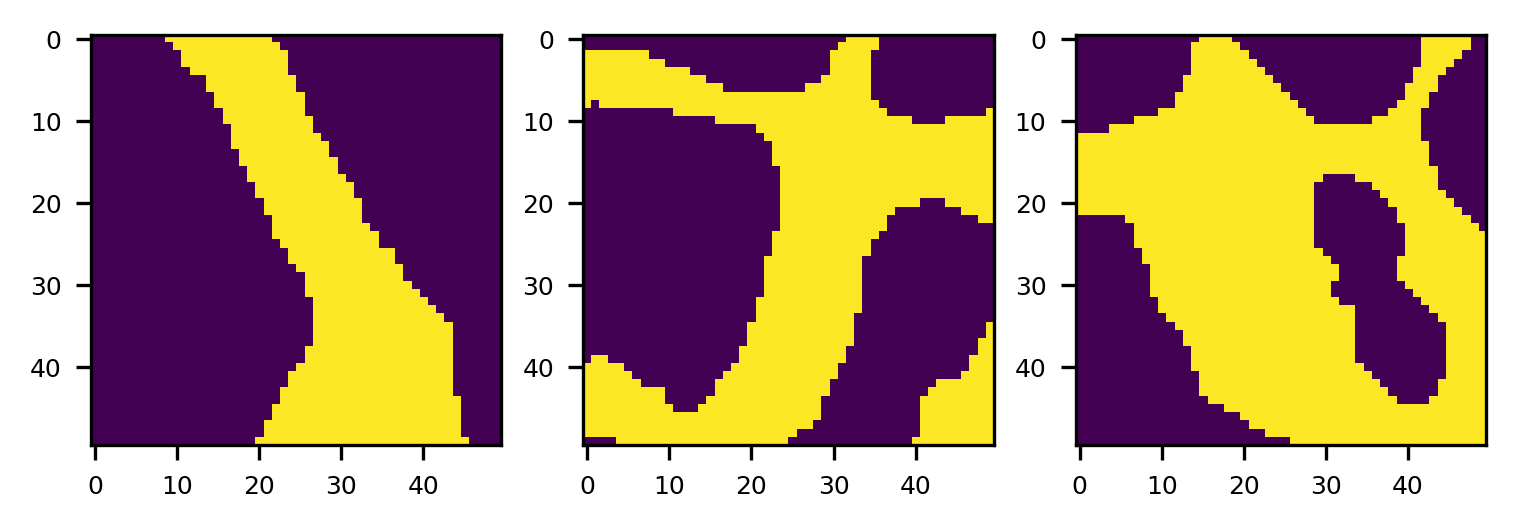

In [28]:
plot_midplanes(L)
plt.show()

## Generate Unstructired Grid Mesh of hexahedra from volume data

In [29]:
mesh = ciclope.voxelFE.vol2ugrid(L, vs, verbose=True)

INFO:root:Calculating cell array
INFO:root:Detecting node coordinates and boundary nodes
INFO:root:Generated the following mesh with 132651 nodes and 46310 elements:
INFO:root:<meshio mesh object>
  Number of points: 132651
  Number of cells:
    hexahedron: 46310
  Point sets: NODES_Y1, NODES_Y0, NODES_X0, NODES_X1, NODES_Z1, NODES_Z0
  Cell sets: CELLS_Y1, CELLS_Y0, CELLS_X0, CELLS_X1, CELLS_Z1, CELLS_Z0
  Cell data: GV


Write the mesh for checking using `meshio`

In [ ]:
mesh.write('foo.vtk')

## Write CalculiX input FE files
### Generate voxel-FE model with constant material properties
If a binary ndarray is given as input, the script `vol2voxelfe` will assume that the material property definition is contained in the FE analysis `.INP` template file.

In [30]:
input_template = "./../../input_templates/tmp_example01_comp_static_bone.inp"

In [31]:
filename_out = './../../test_data/LHDL/3155_D_4_bc/3155_D_4_bc_voxelFE.inp'

In [32]:
ciclope.voxelFE.mesh2voxelfe(mesh, input_template, filename_out, verbose=True)

INFO:root:Found cell_data: GV. cell_data range: True - True.
INFO:root:Start writing INP file
INFO:root:Writing model nodes to INP file
INFO:root:Writing model elements to INP file
INFO:root:Additional nodes sets generated: ['NODES_Y1', 'NODES_Y0', 'NODES_X0', 'NODES_X1', 'NODES_Z1', 'NODES_Z0']
INFO:root:Additional cell sets generated: ['CELLS_Y1', 'CELLS_Y0', 'CELLS_X0', 'CELLS_X1', 'CELLS_Z1', 'CELLS_Z0']
INFO:root:Reading Abaqus template file ./../../input_templates/tmp_example01_comp_static_bone.inp
INFO:root:Model with 132651 nodes and 46310 elements written to file ./../../test_data/LHDL/3155_D_4_bc/3155_D_4_bc_voxelFE.inp


## Solve FE model in calculix
The following section assumes that you have the Calculix solver installed and accessible with the command `ccx_2.17` or for multithread option `ccx_2.17_MT` <br />
The multithread option in CalculiX is activated by defining the number of threads (default=1) used for the calculation.<br />
This is done by setting the env variable *OMP_NUM_THREADS* with:
`export OMP_NUM_THREADS=8`



In [33]:
!export OMP_NUM_THREADS=8; ccx_2.17_MT "./../../test_data/LHDL/3155_D_4_bc/3155_D_4_bc_voxelFE"


************************************************************

CalculiX Version 2.17, Copyright(C) 1998-2020 Guido Dhondt
CalculiX comes with ABSOLUTELY NO WARRANTY. This is free
software, and you are welcome to redistribute it under
certain conditions, see gpl.htm

************************************************************

You are using an executable made on Sun 10 Jan 2021 11:34:19 AM CET

  The numbers below are estimated upper bounds

  number of:

   nodes:       132644
   elements:        46310
   one-dimensional elements:            0
   two-dimensional elements:            0
   integration points per element:            8
   degrees of freedom per node:            3
   layers per element:            1

   distributed facial loads:            0
   distributed volumetric loads:            0
   concentrated loads:            0
   single point constraints:         3305
   multiple point constraints:            1
   terms in all multiple point constraints:            1
   tie con

 *ERROR in calinput: no material was assigned
        to element          799
 *ERROR in calinput: no material was assigned
        to element          800
 *ERROR in calinput: no material was assigned
        to element          801
 *ERROR in calinput: no material was assigned
        to element          802
 *ERROR in calinput: no material was assigned
        to element          803
 *ERROR in calinput: no material was assigned
        to element          804
 *ERROR in calinput: no material was assigned
        to element          805
 *ERROR in calinput: no material was assigned
        to element          806
 *ERROR in calinput: no material was assigned
        to element          807
 *ERROR in calinput: no material was assigned
        to element          808
 *ERROR in calinput: no material was assigned
        to element          809
 *ERROR in calinput: no material was assigned
        to element          810
 *ERROR in calinput: no material was assigned
        to element

 *ERROR in calinput: no material was assigned
        to element         8111
 *ERROR in calinput: no material was assigned
        to element         8112
 *ERROR in calinput: no material was assigned
        to element         8113
 *ERROR in calinput: no material was assigned
        to element         8114
 *ERROR in calinput: no material was assigned
        to element         8115
 *ERROR in calinput: no material was assigned
        to element         8116
 *ERROR in calinput: no material was assigned
        to element         8117
 *ERROR in calinput: no material was assigned
        to element         8118
 *ERROR in calinput: no material was assigned
        to element         8119
 *ERROR in calinput: no material was assigned
        to element         8120
 *ERROR in calinput: no material was assigned
        to element         8121
 *ERROR in calinput: no material was assigned
        to element         8122
 *ERROR in calinput: no material was assigned
        to element

 *ERROR in calinput: no material was assigned
        to element        15456
 *ERROR in calinput: no material was assigned
        to element        15457
 *ERROR in calinput: no material was assigned
        to element        15458
 *ERROR in calinput: no material was assigned
        to element        15459
 *ERROR in calinput: no material was assigned
        to element        15460
 *ERROR in calinput: no material was assigned
        to element        15461
 *ERROR in calinput: no material was assigned
        to element        15462
 *ERROR in calinput: no material was assigned
        to element        15463
 *ERROR in calinput: no material was assigned
        to element        15464
 *ERROR in calinput: no material was assigned
        to element        15465
 *ERROR in calinput: no material was assigned
        to element        15466
 *ERROR in calinput: no material was assigned
        to element        15467
 *ERROR in calinput: no material was assigned
        to element

 *ERROR in calinput: no material was assigned
        to element        22459
 *ERROR in calinput: no material was assigned
        to element        22460
 *ERROR in calinput: no material was assigned
        to element        22461
 *ERROR in calinput: no material was assigned
        to element        22462
 *ERROR in calinput: no material was assigned
        to element        22463
 *ERROR in calinput: no material was assigned
        to element        22464
 *ERROR in calinput: no material was assigned
        to element        22465
 *ERROR in calinput: no material was assigned
        to element        22466
 *ERROR in calinput: no material was assigned
        to element        22467
 *ERROR in calinput: no material was assigned
        to element        22468
 *ERROR in calinput: no material was assigned
        to element        22469
 *ERROR in calinput: no material was assigned
        to element        22470
 *ERROR in calinput: no material was assigned
        to element

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Convert Calculix output to Paraview
The following sections assume that you have **ccx2paraview** and **Paraview** installed and working.<br /> For more info visit: <br />
https://www.paraview.org/ <br />
https://github.com/calculix/ccx2paraview

In [ ]:
import ccx2paraview

In [ ]:
filename_out_base, ext_out = os.path.splitext(filename_out)
ccx2paraview.Converter(filename_out_base + '.frd', ['vtk']).run()

#### Visualize results in Paraview

In [ ]:
!paraview filename_out_base + '.vtk'

![](./../test_data/trabecular_bone/U3.png)

Visuailzation with itkwidgtes (does not show field data..)

In [ ]:
import vtk

In [ ]:
reader = vtk.vtkUnstructuredGridReader()
reader.SetFileName(filename_vtk)
reader.Update()
grid = reader.GetOutput()

In [ ]:
view(geometries=grid)